# DQN on “FreewayDeterministic-v4"

### Imports

In [1]:
import sys
from pathlib import Path

# Add the src folder to sys.path
sys.path.append(str(Path().resolve().parent / "src"))

In [2]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from collections import deque

In [3]:
env = gym.make("FreewayDeterministic-v4", render_mode="rgb_array")
env.seed(0)
print("State shape: ", env.observation_space.shape)
print("Number of actions: ", env.action_space.n)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


State shape:  (210, 160, 3)
Number of actions:  3


Inspect a frame:

/home/yiannisparask/Projects/aidl-b02-task/gym-env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


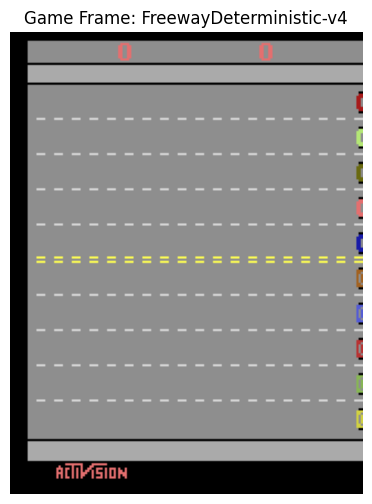

In [5]:
state, _ = env.reset()
frame = env.render()

plt.figure(figsize=(6, 6))
plt.imshow(frame)
plt.axis("off") 
plt.title("Game Frame: FreewayDeterministic-v4")
plt.show()

In [4]:
from torchvision import transforms as T


def preprocess_frame(frame):
    """
    Preprocess the frame by cropping black borders, resizing, and normalizing.

    Args:
        frame (numpy.ndarray): The original frame.

    Returns:
        numpy.ndarray: The preprocessed frame.
    """
    # Convert to grayscale
    gray_frame = np.mean(frame, axis=2).astype(np.uint8)

    # Ignore the bottom 20 pixels (adjust as needed for your environment)
    gray_frame = gray_frame[:-20, :]

    # Detect non-black regions
    non_black_indices = np.where(gray_frame > 20)

    # Find the bounding box of the non-black pixels
    y_min, y_max = np.min(non_black_indices[0]), np.max(non_black_indices[0])
    x_min, x_max = np.min(non_black_indices[1]), np.max(non_black_indices[1])

    # Crop the frame
    cropped_frame = frame[y_min : y_max + 1, x_min : x_max + 1]
    
    preprocess = T.transforms.Compose(
        [
            T.transforms.ToPILImage(),
            T.transforms.Grayscale(),
            T.transforms.Resize((80, 80)),
            T.transforms.ToTensor(),
        ]
    )
    return preprocess(cropped_frame).squeeze(0).numpy()

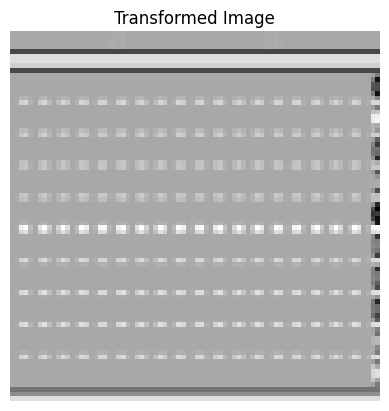

In [12]:
frame = env.render()
# Apply the transformation
transformed_img = preprocess_frame(frame)

# Display the transformed image
plt.imshow(transformed_img, cmap="gray")
plt.title("Transformed Image")
plt.axis("off")
plt.show()

In [5]:
def train_agent(env, agent, num_episodes):
    scores = []
    scores_window = deque(maxlen=100)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state)
        stacked_state = np.stack([state] * 4, axis=0)
        episode_reward = 0
        done = False

        while not done:
            action = agent.act(stacked_state)
            next_frame, reward, terminated, truncated, _ = env.step(
                action
            )  # info not used
            done = terminated or truncated
            next_state = preprocess_frame(next_frame)
            stacked_next_state = np.append(stacked_state[1:, :, :], np.expand_dims(next_state, 0), axis=0)

            agent.step(stacked_state, action, reward, stacked_next_state, done)
            stacked_state = stacked_next_state
            episode_reward += reward

        scores.append(episode_reward)
        scores_window.append(episode_reward)
        
        # Debug epsilon statements
        # print(f"Episode Reward: {episode_reward}")
        #print(f"Epsilon: {agent.epsilon}")
        # print(f"Replay Buffer Size: {len(agent.replay_buffer)}")

        print(f"Episode {episode}/{num_episodes}, Reward: {episode_reward:.2f}, "
              f"Average Score: {np.mean(scores_window):.2f}, Epsilon: {agent.epsilon:.2f}")

        if np.mean(scores_window) >= 200.0 and len(scores_window) == scores_window.maxlen:
            print(f"Environment solved in {episode} episodes!")
            torch.save(agent.q_network.state_dict(), "solved_dqn.pth")
            break
        

    return scores

In [6]:
def plot_rewards(rewards):
    '''
    Plot the rewards over the episodes.
    
    Args:
    - rewards: A list of rewards.
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Rewards")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Training Rewards over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

Using device: cuda
Epsilon: 0.1
Episode 1/100, Reward: 0.00, Average Score: 0.00, Epsilon: 0.10
Epsilon: 0.1
Episode 2/100, Reward: 0.00, Average Score: 0.00, Epsilon: 0.10
Epsilon: 0.1
Episode 3/100, Reward: 0.00, Average Score: 0.00, Epsilon: 0.10
Epsilon: 0.1
Episode 4/100, Reward: 0.00, Average Score: 0.00, Epsilon: 0.10
Epsilon: 0.1
Episode 5/100, Reward: 0.00, Average Score: 0.00, Epsilon: 0.10
Epsilon: 0.1
Episode 6/100, Reward: 7.00, Average Score: 1.17, Epsilon: 0.10
Epsilon: 0.1
Episode 7/100, Reward: 17.00, Average Score: 3.43, Epsilon: 0.10
Epsilon: 0.1
Episode 8/100, Reward: 20.00, Average Score: 5.50, Epsilon: 0.10
Epsilon: 0.1
Episode 9/100, Reward: 19.00, Average Score: 7.00, Epsilon: 0.10
Epsilon: 0.1
Episode 10/100, Reward: 21.00, Average Score: 8.40, Epsilon: 0.10
Epsilon: 0.1
Episode 11/100, Reward: 20.00, Average Score: 9.45, Epsilon: 0.10
Epsilon: 0.1
Episode 12/100, Reward: 21.00, Average Score: 10.42, Epsilon: 0.10
Epsilon: 0.1
Episode 13/100, Reward: 23.00, Ave

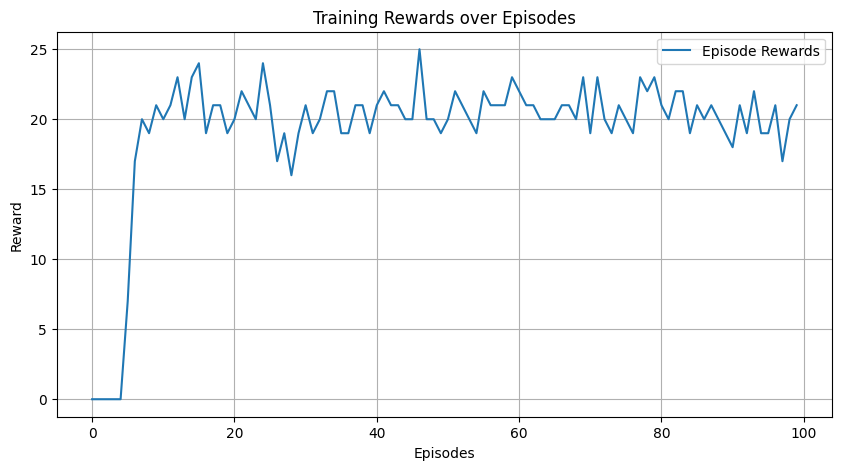

In [7]:
from agent import Agent

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

state_size = env.observation_space.shape
action_size = env.action_space.n

agent = Agent(state_size, action_size, device, buffer_size=5000)
num_episodes = 100

scores = train_agent(env, agent, num_episodes)

plot_rewards(scores)

### Inference time!

In [ ]:
agent.q_network.load_state_dict(torch.load("solved_dqn.pth"))

In [ ]:
video = VideoRecorder(env, "videos/freeway_dqn.mp4", enabled=True)
state = env.reset()
scores = 0
for i in range(1000):
    env.render()
    video.capture_frame()
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    scores += reward
    if done:
        break
video.close()
env.close()

print(f"Score: {scores}")

In [ ]:
from base64 import b64encode

def render_mp4(videopath: str) -> str:
    """
    Gets a string containing a b4-encoded version of the MP4 video
    at the specified path.
    """
    mp4 = open(videopath, "rb").read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return (
        f'<video width=400 controls><source src="data:video/mp4;'
        f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
    )

In [ ]:
from IPython.display import HTML

html = render_mp4("videos/freeway_dqn.mp4")
HTML(html)

## Model-based DQN